# Midterm Project
## Carlos Olivas ID# 861045506

Below we will attempt to create a predictive model for wine. The data to be used contains 11 features that describe each wine and a quality score for the wine. The scores were given by wine experts. This data was previously used by a research group that found that the best model was a support vector machine (SVM). We will attempt to create an SVM model.

We'll start by importing all the necessary libraries.

In [272]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN

In [ ]:
# read in the data from the csv file into a pandas DataFrame
wine_data = pd.read_csv('winequality-red.csv', sep=';')

# format the column names
wine_data.columns = wine_data.columns.str.strip().str.lower().str.replace(' ', '_')


To begin, we'll create a graph to show the distribution of the wines amongst the different quality scores to get a better understanding of our data. 

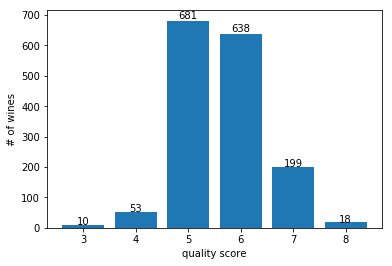

In [191]:
# get the count for each quality score to be used to show how imbalanced the data is
quality_counts = wine_data['quality'].value_counts()

# create and show bar graph to show distribution of wines' in quality scores
bars = plt.bar(quality_counts.keys(), quality_counts)
plt.xlabel('quality score')
plt.ylabel('# of wines')

# add annotations to the bars
for bar in bars:
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 1.01*bar_height, str(bar_height), ha='center')
plt.show()


As we can see, although the possible quality score can range from 1-10, the data contains wines with scores between 3-8. Next we will begin to create a basic SVM model. The data will be split into a 70-30, with 70% training data, 15% validation data, and 15% test data. 

In [460]:
# split the data into sets for training, validation, and test
y = wine_data['quality']
x = wine_data.drop('quality', axis=1)

# split data as 70% train and 30% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# split test data into validation data and test data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# scale the data
sc = StandardScaler()
x_train_s = sc.fit_transform(x_train)
x_val_s = sc.transform(x_val)
x_test_s = sc.transform(x_test)

# create the model using SVM
svc = SVC()
# svc = SVC(gamma='scale', decision_function_shape='ovo')
svc.fit(x_train_s, y_train)
svc_predict = svc.predict(x_val_s)

svc_acc_score = accuracy_score(y_val, svc_predict)

print('SVM basic accuracy: %f' % svc_acc_score)

SVM basic accuracy: 0.683333


In [479]:
svc.fit(x_train_s, y_train)
y_pred = svc.predict(x_test_s)

svc_acc_score = accuracy_score(y_test, y_pred)

print('SVM basic accuracy: %f' % (svc_acc_score))

SVM basic accuracy: 0.595833


The default values of the SVC render a 68.33% accuracy with the validation data, and 59.58% with the testing data. We'll see if we can find better parameters to increase that percentage using Grid Search. 

In [464]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'],
               'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator=svc, param_grid=parameters, scoring='accuracy', cv=3)
grid_search.fit(x_train_s, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_parameters)
print('Automated projected accuracy: %f' % best_accuracy)

{'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}
Automated projected accuracy: 0.624665


The greatest accuracy the grid search was able to achieve with the indicated parameters came out less than the accuracy we were able to achieve with the default setting for SVC. Granted, it was only cross-validating with the training data itself. The penalty and the kernel are the same as the default values for SVC. We will see how the gamma selected by the grid search performs against the validation data. 

In [482]:
svc.gamma = 0.3
svc.fit(x_train_s, y_train)
y_pred = svc.predict(x_val_s)
svc_acc_score = accuracy_score(y_val, y_pred)
print('SVM accuracy w/gamma = 0.3: %f' % (svc_acc_score))

SVM accuracy w/gamma = 0.3: 0.662500


The accuracy against the valdation data was better than the grid search projection, but still less than the default value of print(best_parameters). So I wanted to see what other values for gamma could produce:

In [483]:
for g in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    svc.gamma = g
    svc.fit(x_train_s, y_train)
    y_pred = svc.predict(x_val_s)

    svc_acc_score = accuracy_score(y_val, y_pred)

    print('SVM accuracy w/gamma = %0.1f: %f' % (g, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.683333
SVM accuracy w/gamma = 0.2: 0.675000
SVM accuracy w/gamma = 0.3: 0.662500
SVM accuracy w/gamma = 0.4: 0.670833
SVM accuracy w/gamma = 0.5: 0.670833
SVM accuracy w/gamma = 0.6: 0.670833
SVM accuracy w/gamma = 0.7: 0.679167
SVM accuracy w/gamma = 0.8: 0.679167
SVM accuracy w/gamma = 0.9: 0.654167


We can see that a gamma value of 0.1 actually produces the best accuracy of about 68.33%. Now, let's see how this performs on the test data. 

In [484]:
svc.gamma = 0.1
svc.fit(x_train_s, y_train)
y_pred = svc.predict(x_test_s)

svc_acc_score = accuracy_score(y_test, y_pred)

print('SVM accuracy w/gamma = %0.1f: %f' % (svc.gamma, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.595833


The acuruacy of predicting the test data quality scores. So, there is room for improvement. So the following will be attempts to increase the accuracy with the validation data before using the model on the test data. One method we can follow is feature selection. The first method of feature selection we will attempt will be to remove the features that seem to have the lowest correlation to the wine's quality score. Below, we will see a heatmap of the correlation of each feature to the quality score of each wine. 

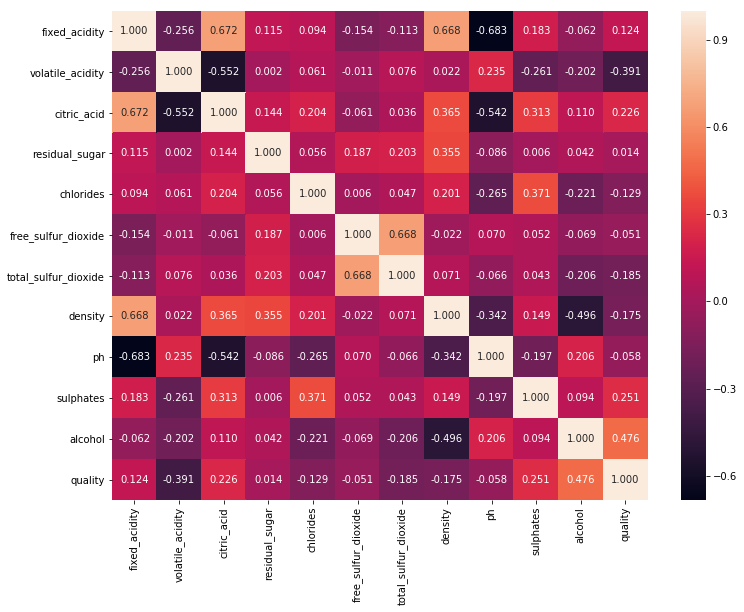

In [83]:
plt.figure(figsize=(12, 9))
sns.heatmap(wine_data.corr(), annot=True, annot_kws={"size": 10}, fmt='.3f', linewidths=0)
plt.show()

If we look at the last row of the heatmap, we can see that the least correlated feature is the residual sugar, followed by free sulfur dioxide and pH. So we'll remove those features from the data and see if that will help improve the model.

In [494]:
x_train_fs = x_train.drop(['residual_sugar', 'free_sulfur_dioxide', 'ph'], axis=1)
x_val_fs = x_val.drop(['residual_sugar', 'free_sulfur_dioxide', 'ph'], axis=1)
x_test_fs = x_test.drop(['residual_sugar', 'free_sulfur_dioxide', 'ph'], axis=1)

Now we have to rescale everything and run the model again using different values for gamma to find the best predictive accuracy.

In [496]:
# re-scale the data
sc = StandardScaler()
x_train_fs_s = sc.fit_transform(x_train_fs)
x_val_fs_s = sc.transform(x_val_fs)
x_test_fs_s = sc.transform(x_test_fs)

for g in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    svc.gamma = g
    svc.fit(x_train_fs_s, y_train)
    y_pred = svc.predict(x_val_fs_s)

    svc_acc_score = accuracy_score(y_val, y_pred)

    print('SVM accuracy w/gamma = %0.1f: %f' % (g, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.695833
SVM accuracy w/gamma = 0.2: 0.695833
SVM accuracy w/gamma = 0.3: 0.679167
SVM accuracy w/gamma = 0.4: 0.666667
SVM accuracy w/gamma = 0.5: 0.658333
SVM accuracy w/gamma = 0.6: 0.654167
SVM accuracy w/gamma = 0.7: 0.650000
SVM accuracy w/gamma = 0.8: 0.629167
SVM accuracy w/gamma = 0.9: 0.641667


As we can see, a gamma value of 0.1 or 0.2, inclusively, would render the predictive accuracy of 69.58% of the validation data. An improvement from the highest predictive accuracy from above. Let's see if the improvement is also seen in with the test data. 

In [498]:
svc.gamma = 0.2
svc.fit(x_train_fs_s, y_train)
y_pred = svc.predict(x_test_fs_s)

svc_acc_score = accuracy_score(y_test, y_pred)

print('SVM accuracy w/gamma = %0.1f: %f' % (svc.gamma, svc_acc_score))

SVM accuracy w/gamma = 0.2: 0.600000


The predictive accuracy of the test data did increase to 60%. But, perhaps we can tru a different method of feature selection. Another method we can try is univariate selection. This uses scikit-learn's SelectKBest class to run different statistical tests to show the best features. 

In [499]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(x_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                   Specs        Score
6   total_sulfur_dioxide  2104.698310
5    free_sulfur_dioxide   201.707783
10               alcohol    33.172939
1       volatile_acidity    12.220197
2            citric_acid    12.024372
0          fixed_acidity     9.950168
9              sulphates     3.346170
3         residual_sugar     2.089961
4              chlorides     0.522017
8                     ph     0.162282


For this instance we chose to use the chi-squared test. The test allows us to see which features are most likely to be independent and be irrelevant to the classification. Based on the scores above, it would seem that ph and chlorides would be good feature to exclude from the model. 

In [510]:
x_train_fs = x_train.drop(['ph'], axis=1)
x_val_fs = x_val.drop(['ph'], axis=1)
x_test_fs = x_test.drop(['ph'], axis=1)

# re-scale the data
sc = StandardScaler()
x_train_fs_s = sc.fit_transform(x_train_fs)
x_val_fs_s = sc.transform(x_val_fs)
x_test_fs_s = sc.transform(x_test_fs)

for g in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    svc.gamma = g
    svc.fit(x_train_fs_s, y_train)
    y_pred = svc.predict(x_val_fs_s)

    svc_acc_score = accuracy_score(y_val, y_pred)

    print('SVM accuracy w/gamma = %0.1f: %f' % (g, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.700000
SVM accuracy w/gamma = 0.2: 0.679167
SVM accuracy w/gamma = 0.3: 0.670833
SVM accuracy w/gamma = 0.4: 0.679167
SVM accuracy w/gamma = 0.5: 0.675000
SVM accuracy w/gamma = 0.6: 0.662500
SVM accuracy w/gamma = 0.7: 0.666667
SVM accuracy w/gamma = 0.8: 0.662500
SVM accuracy w/gamma = 0.9: 0.679167


We can see that removing the feature ph has given us a marginally better predictive accuracy of about 70% with gamma values of 0.1. This will be the accepted feature selection. Now we will see how this model predicts the test data.

In [511]:
svc.gamma = 0.2
svc.fit(x_train_fs_s, y_train)
y_pred = svc.predict(x_test_fs_s)

svc_acc_score = accuracy_score(y_test, y_pred)

print('SVM accuracy w/gamma = %0.1f: %f' % (svc.gamma, svc_acc_score))

SVM accuracy w/gamma = 0.2: 0.604167


While this is the best accuracy we've seen at 60.41%, it could hopefully get better. As we saw above, there is a ridiculously greater number of wines with quality scores 5 and 6 than any of the other scores. This  imbalance in the data could cause the model to bias towards the over-represented classes. One method to correct this would be to undersample the over-represented classes. This would entail randomly removing wines of the majority class from the training data. 

In [512]:
x_train_fs = x_train.drop(['ph'], axis=1)
x_val_fs = x_val.drop(['ph'], axis=1)
x_test_fs = x_test.drop(['ph'], axis=1)

# resample the training data using under-sampling
rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
x_train_fsu, y_train_u = rus.fit_resample(x_train_fs, y_train)

# re-scale the data
sc = StandardScaler()
x_train_fsu_s = sc.fit_transform(x_train_fsu)
x_val_fs_s = sc.transform(x_val_fs)
x_test_fs_s = sc.transform(x_test_fs)

for g in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    svc.gamma = g
    svc.fit(x_train_fsu_s, y_train_u)
    y_pred = svc.predict(x_val_fs_s)

    svc_acc_score = accuracy_score(y_val, y_pred)

    print('SVM accuracy w/gamma = %0.1f: %f' % (g, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.437500
SVM accuracy w/gamma = 0.2: 0.433333
SVM accuracy w/gamma = 0.3: 0.433333
SVM accuracy w/gamma = 0.4: 0.441667
SVM accuracy w/gamma = 0.5: 0.445833
SVM accuracy w/gamma = 0.6: 0.450000
SVM accuracy w/gamma = 0.7: 0.450000
SVM accuracy w/gamma = 0.8: 0.450000
SVM accuracy w/gamma = 0.9: 0.445833


As we can see, the projected prediction accuracies went down. This could be due to the smaller size of the training data. Another method we can attempt is over-sampling, wherein the minority class is oversampled with replacement.

In [515]:
ros = RandomOverSampler(sampling_strategy='minority')

x_train_fs = x_train.drop(['ph'], axis=1)
x_val_fs = x_val.drop(['ph'], axis=1)
x_test_fs = x_test.drop(['ph'], axis=1)

x_train_fso, y_train_o = ros.fit_sample(x_train_fs, y_train)

# re-scale the data
sc = StandardScaler()
x_train_fso_s = sc.fit_transform(x_train_fso)
x_val_fs_s = sc.transform(x_val_fs)
x_test_fs_s = sc.transform(x_test_fs)

for g in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    svc.gamma = g
    svc.fit(x_train_fso_s, y_train_o)
    y_pred = svc.predict(x_val_fs_s)

    svc_acc_score = accuracy_score(y_val, y_pred)

    print('SVM accuracy w/gamma = %0.1f: %f' % (g, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.679167
SVM accuracy w/gamma = 0.2: 0.650000
SVM accuracy w/gamma = 0.3: 0.658333
SVM accuracy w/gamma = 0.4: 0.662500
SVM accuracy w/gamma = 0.5: 0.650000
SVM accuracy w/gamma = 0.6: 0.654167
SVM accuracy w/gamma = 0.7: 0.658333
SVM accuracy w/gamma = 0.8: 0.658333
SVM accuracy w/gamma = 0.9: 0.658333


In [516]:
svc.gamma = 0.1
svc.fit(x_train_fso_s, y_train_o)
y_pred = svc.predict(x_test_fs_s)
svc_acc_score = accuracy_score(y_test, y_pred)

print('SVM accuracy w/gamma = %0.1f: %f' % (svc.gamma, svc_acc_score))

SVM accuracy w/gamma = 0.1: 0.566667


Unfortunately, oversampling the minority data did not produce a a great prediction accuracy. So the greatest accuracy we achieved of the test data was 60.47%. Different divisions of the data into training and testing sets would give different prediction accuracies. I believe that it would be difficult to produce an accurate model of this data due to the fact that the quality score are subjective. There are multiple examples where wine experts were tricked into giving a cheaper wine a higher rating just by placing it in a different bottle. So the consistency of the wine experts' ratings could be doubtful. 